# Conv-model with Feature Engineering

## Import packages

In [1]:
import glob
import os
import sys

sys.path.append('..')

In [2]:
import torch
import torch.nn as nn

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits

from tqdm import tqdm

from inverse_problem import HinodeME
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer

from inverse_problem.nn_inversion.model_pi_mlp_conv import PIMLPConvNet
from inverse_problem.nn_inversion import conv1d_transform_rescale, normalize_spectrum

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from datetime import datetime
from pathlib import Path

model_name = 'fe_model'

current_time = str(datetime.now().strftime('%Y-%m-%d_%H-%M'))

save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device.type)

cpu


## Dataset

In [3]:
filename = '../data/parameters_base.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

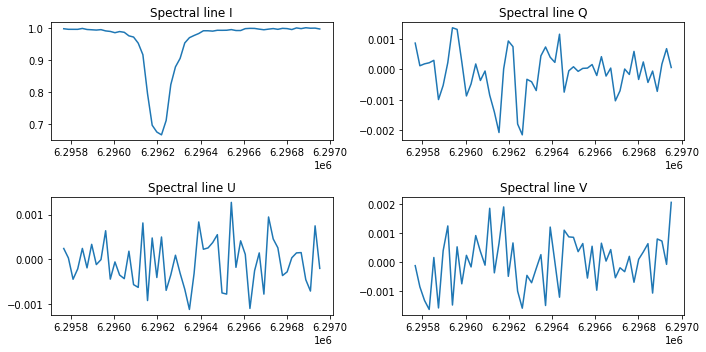

In [5]:
line_type = ['I', 'Q', 'U', 'V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
for i in range(4):
    ax[i // 2][i % 2].plot(line_arg, sample['X'][0][:, i])
    ax[i // 2][i % 2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight=True)
fig.set_facecolor('xkcd:white')

## Data Filtering

In [ ]:
params = fits.open(filename)[0].data

In [ ]:
def params_masked_rows(pars_arr):
    max_par_values = np.array([pars_arr[:, i].max() for i in range(len(names))])
    min_par_values = np.array([pars_arr[:, i].min() for i in range(len(names))])

    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)


def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)

In [ ]:
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

## Dataloader

In [10]:
factors, cont_scale = [1, 1000, 1000, 1000], 40000
angle_transformation, logB = True, True
transform_name = "conv1d_transform_rescale"
batch_size = 128
num_workers = 1 if device.type == 'gpu' else 0

train_loader, val_loader = make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors=factors, cont_scale=cont_scale,
                                       logB=logB, angle_transformation=angle_transformation,
                                       batch_size=128, num_workers=num_workers)

sample_batch = next(iter(train_loader))

print('Size of spectrum batch: ', sample_batch['X'][0].shape)
print('Size of cont batch: ', sample_batch['X'][1].shape)
print('Size of true params batch: ', sample_batch['Y'].shape)

print(f'\nNumber of batches for train: {len(train_loader)}, for validation: {len(val_loader)}')

Size of spectrum batch:  torch.Size([128, 4, 56])
Size of cont batch:  torch.Size([128, 1])
Size of true params batch:  torch.Size([128, 11])

Number of batches for train: 22767, for validation: 2530


## Model

In [11]:
model = PIMLPConvNet(n_blocks=6, in_dim=(4, 64, 64, 128, 128, 256), out_dim=(64, 64, 128, 128, 256, 256),
                     kernel_size=(3, 3, 3, 3, 3, 3), padding=(1, 1, 1, 1, 1, 1), activation='elu', dropout=0.05,
                     batch_norm=True, pool=(None, 'max', None, 'max', None, None), hidden_dims=(100, 100),
                     bottom_output=100, number_readout_layers=2, top_output=11)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device);

## Model Training

In [10]:
def fit_step(dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break

            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)

            outputs = model(x)

            optimizer.zero_grad()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_it += 1

            if train_it % 10 == 0:
                pbar_outer.update(10)

        return train_loss / train_it


def eval_step(dataloader):
    model.eval()
    val_loss = 0.0
    val_it = 0

    for i, inputs in enumerate(dataloader):
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)

        with torch.no_grad():
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it


def save_model(path, epoch, loss):
    """
    Args:
        path (str): path to save model to
        epoch (int): optional
        loss (float): optional, validation loss
    Returns:
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + '_' + model_name + '_' f'ep{epoch}.pt')


def train(n_epoch, logdir=None, path_to_save=None):
    loss_history = []
    best_valid_loss = float('inf')

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=n_epoch, position=0, leave=True) as pbar_outer:
        for epoch in range(n_epoch):
            train_loss = fit_step(train_loader)
            val_loss = eval_step(val_loader)
            loss_history.append((train_loss, val_loss))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))

            if path_to_save:
                if val_loss < best_valid_loss:
                    best_valid_loss = val_loss
                    save_model(path_to_save, epoch, val_loss)

            with open(os.path.join(logdir, 'history_' + model_name + '.txt'), 'w') as f:
                for i, item in enumerate(history):
                    f.write(f"Train loss in epoch {i}: {item[0]: .4f}, val_loss: {item[1]:.4f}\n")

    return loss_history

In [11]:
%%time

num_epochs = 5
history = train(n_epoch=num_epochs,
                logdir=save_path,
                path_to_save=save_path)

epoch:  50%|███████████████████                   | 1/2 [01:21<01:21, 81.80s/it]


Epoch 001 train_loss: 0.6535 val_loss 0.2188


epoch: 100%|██████████████████████████████████████| 2/2 [02:42<00:00, 81.15s/it]


Epoch 002 train_loss: 0.0127 val_loss 0.0100
CPU times: user 2min 40s, sys: 6.24 s, total: 2min 46s
Wall time: 2min 42s


## Model Analysis

Два варианта:
- Оценка понимание моделью симуляции спектров из референсных значений, полученных обращением реальных спектров
- Оценка качество работы на реальных спектрах

### Реферер
Посмотрим что он из себя представляет (на самом деле база с параметрами и есть композиция нескольких рефереров)

Несколько примеров лежат подготовленные на гугл диске:
https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [20]:
from inverse_problem.nn_inversion.transforms import normalize_output

path_to_refer = '../data/hinode_source/20140926_170005.fits'
# можно с помощью функции сразу нормировать выходы так как это делается для сети, но посмотреть мы можем и сырые данные

refer_unnormalized, names = open_param_file(path_to_refer, normalize=False)
ref_unnormalized_2d = refer_unnormalized.reshape(-1, 11)

refer_shape = refer_unnormalized.shape

ref_2d = normalize_output(ref_unnormalized_2d.copy(),
                          angle_transformation=angle_transformation,
                          logB=logB)

refer = ref_2d.reshape(refer_shape).copy()

print('\n', refer_shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift

 (512, 873, 11)


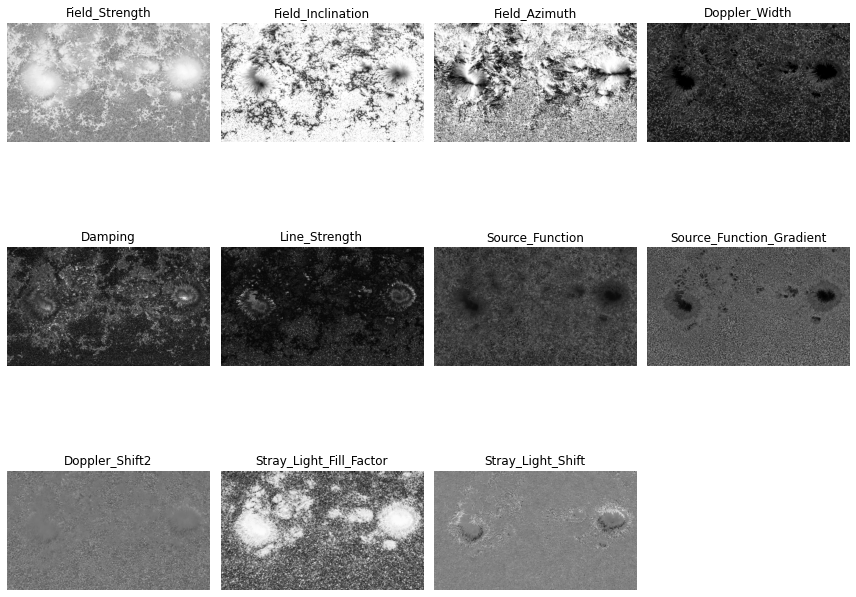

In [21]:
plot_params(refer, names=names)

### Refer Filtering

In [ ]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(refer.shape)

masked_ref_unnormalized_2d = create_masked_array(ref_unnormalized_2d)
masked_ref_unnormalized = masked_ref_unnormalized_2d.reshape(refer.shape)

### Тестируем модель на симуляции данных из реферера

тут нам препроцессинг может упростить PregenDataset, можно и руками с помощью  BatchMe приготовить данные (он там и есть). Дальше надо загрузить 500k параметров и сделать симуляцию, поэтому работает это долго (в SpectrumDataset генерация во время обучения, поэтому надо только считать параметры и это быстро)



In [22]:
%%time

transform = conv1d_transform_rescale(factors=factors, angle_transformation=angle_transformation,
                                     cont_scale=cont_scale, logB=logB)
test_dataset = PregenSpectrumDataset(data_arr=masked_ref_unnormalized, source='refer', transform=transform)

CPU times: user 54.6 s, sys: 20.3 s, total: 1min 14s
Wall time: 1min 17s


In [23]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [24]:
%%time

model.eval()
with torch.no_grad():
    predicted = model(sim_x)

KeyboardInterrupt: 

## Обратные преобразования параметров

In [ ]:
import math


def angle_transform(x):
    if angle_transformation:
        return sine_degree(x)
    else:
        return x


def sine_degree(x):
    return np.sin(x * np.pi / 180)


params_max = [math.log(5000) if logB else 5000, 1 if angle_transformation else 180, 1 if angle_transformation else 180,
              90, 1.5, 100, 38603,
              60464, 10, 1, 10]
params_min = [0, 0, 0, 20, 0, 0.01, 0, 0, -10, 0, -10]


def inverse_transformation(params_to_transform, inv_logB=True, inv_angle_transformation=True):
    params_range = np.array(params_max).reshape(-1, 1) - np.array(params_min).reshape(-1, 1)

    transformed_params = params_to_transform.reshape(-1, 11).T * params_range + np.array(params_min)[:, np.newaxis]

    transformed_params = transformed_params.T

    if inv_logB:
        transformed_params[:, 0] = np.exp(transformed_params[:, 0])

    if inv_angle_transformation:
        transformed_params[:, 1:3] = np.arcsin(transformed_params[:, 1:3])

    return transformed_params

In [ ]:
predicted = inverse_transformation(predicted)

In [25]:
plot_pred_vs_refer(predicted, refer, output_index=0)

NameError: name 'predicted' is not defined

In [ ]:
compute_metrics(refer, predicted)

## Проверка на реальных спектрах
Спектры лежат в отдельной папочке sp_..... (много папочек в папочках, оставила так же как и лежит на хиноде). Спектры получаются последовательным сканированием щели, и результаты каждой в своем фитсе, всего 873, внутри каждой щели 512 спектров.  

In [19]:
path_to_folder = '../data/hinode_source'

# date as a list with year, month,day, hour
date = ['2014', '09', '26', '17']

sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')

sp_path = os.path.join(sp_folder, date[0], date[1], date[2], 'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]

sp_lines = sorted(glob.glob(sp_path + '*.fits'))
print(f'Number of files: {len(sp_lines)}')

Number of files: 873


In [20]:
def open_spectrum_data(sp_folder, date, idx):
    """
    path should start from the folder included in level1 folder, with data year 
    only for this path_to_folder like this sp_20140926_170005
    """
    sp_path = os.path.join(sp_folder, date[0], date[1], date[2], 'SP3D')
    sp_path = glob.glob(f'{sp_path}/*/')[0]
    sp_lines = sorted(glob.glob(sp_path + '*.fits'))
    #print(f'Number of files: {len(sp_lines)}')
    return fits.open(sp_lines[idx])


def real_spectra(spectra_file):
    """
    Extracting and plotting spectral lines from fits
    Why multiply to numbers?
    """
    real_I = spectra_file[0].data[0][:, 56:].astype('float64') * 2
    real_Q = spectra_file[0].data[1][:, 56:].astype('float64')
    real_U = spectra_file[0].data[2][:, 56:].astype('float64')
    real_V = spectra_file[0].data[3][:, 56:].astype('float64')
    return np.concatenate((real_I, real_Q, real_U, real_V), axis=1)

In [38]:
def plot_spectrum(sp_folder, date, path_to_refer, idx_0, idx_1):
    """
    Plot spectrum, corresponding referens values of parameters and model spectrum
    idx_0 - index of line in one spectrum file (512), idx_1 - index of spectrum file sorted by time (873 in total)
    """
    refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
    spectra_file = open_spectrum_data(sp_folder, date, idx_1)
    real_sp = real_spectra(spectra_file)
    full_line = real_sp[idx_0, :]
    fig, ax = plt.subplots(2, 2, figsize=(10, 5))
    line_type = ['I', 'Q', 'U', 'V']
    print('Real spectrum for parameters')
    #print(', '.join([names[i]+f': {refer[idx_0,idx_1, i]:.2f}' for i in range(11)]))
    cont_int = np.max(full_line)

    for i in range(4):
        ax[i // 2][i % 2].plot(full_line[i * 56:i * 56 + 56] / cont_int);
        ax[i // 2][i % 2].set_title(f'Spectral line {line_type[i]}')
    fig.suptitle(f'Real spectrum with empiric intensity {cont_int :.1f}', fontsize=16, fontweight="bold")
    fig.set_tight_layout(tight=True)
    fig.set_facecolor('xkcd:white')

    return full_line, cont_int


def plot_model_spectrum(refer, names, idx_0, idx_1):
    param_vec = refer[idx_0, idx_1, :]
    obj = HinodeME(param_vec)
    profile = obj.compute_spectrum(with_ff=True, with_noise=True)
    fig, ax = plt.subplots(2, 2, figsize=(10, 5))
    line_type = ['I', 'Q', 'U', 'V']
    print('Model spectrum for parameters')
    print(', '.join([names[i] + f': {refer[idx_0, idx_1, i]:.2f}' for i in range(11)]))

    for i in range(4):
        ax[i // 2][i % 2].plot(profile[0, :, i]);
        ax[i // 2][i % 2].set_title(f'Spectral line {line_type[i]}')
    fig.set_tight_layout(tight=True)
    fig.suptitle(f'Model spectrum with estimated intensity {obj.cont:.1f}', fontsize=16, fontweight="bold")
    fig.set_facecolor('xkcd:white')

    return profile, obj.cont

Real spectrum for parameters
Model spectrum for parameters
Field_Strength: 302.78, Field_Inclination: 86.39, Field_Azimuth: 105.42, Doppler_Width: 27.02, Damping: 0.22, Line_Strength: 7.18, Source_Function: 7479.19, Source_Function_Gradient: 18128.35, Doppler_Shift2: 0.55, Stray_Light_Fill_Factor: 0.09, Stray_Light_Shift: -0.27


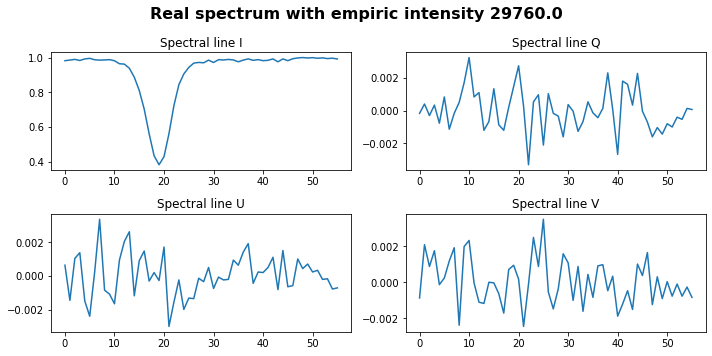

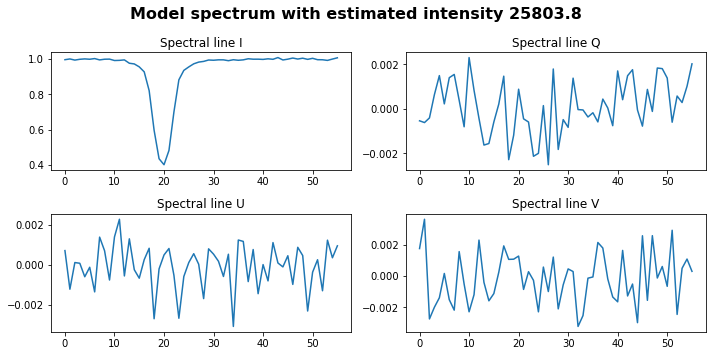

In [39]:
# можно побегать индексами и посравнивать спектры
idx_0, idx_1 = 10, 10
cont_int, real_line = plot_spectrum(sp_folder, date, path_to_refer, idx_0, idx_1)
refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
profile, cont_int = plot_model_spectrum(refer, names, idx_0, idx_1)

In [30]:
def read_spectrum_for_refer(sp_folder, date):
    real_samples = np.zeros((512, 873, 224))
    cont = np.zeros((512, 873))
    for idx_1 in range(873):
        line = real_spectra(open_spectrum_data(sp_folder, date, idx_1))
        real_samples[:, idx_1, :] = line
        cont[:, idx_1] = np.max(line, axis=1)
    real_samples = real_samples.reshape(-1, 224)
    cont = cont.reshape(-1, 1)
    return real_samples / cont, cont

## Подготовка реальных спектров для модели

In [ ]:
def prepare_real_conv(sp_folder, date, factors=None, cont_scale=None, device=None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1, 56, 4), order='F'),
                                           factors=factors,
                                           )
    norm_cont = cont / cont_scale
    norm_real_samples = np.reshape(norm_real_samples, (-1, 4, 56), order='F')
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x

In [31]:
%%time

real_x = prepare_real_conv(sp_folder, date, factors=factors, cont_scale=cont_scale, device=device)

CPU times: user 5.01 s, sys: 2.46 s, total: 7.47 s
Wall time: 9.41 s


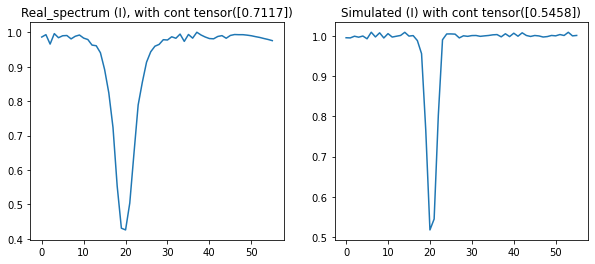

In [33]:
# тоже можно побегать индексом и увидеть, что наши симуляции довольно сильно отличаются
idx = 20
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1);
plt.plot(real_x[0][idx, 0]);
plt.title(f'Real_spectrum (I), with cont {real_x[1][idx]}')
plt.subplot(1, 2, 2);
plt.plot(sim_x[0][idx, 0]);
plt.title(f'Simulated (I) with cont {sim_x[1][idx]}');

In [34]:
model.eval()
with torch.no_grad():
    predicted_real = model(real_x)

In [ ]:
predicted_real = inverse_transformation(predicted_real)

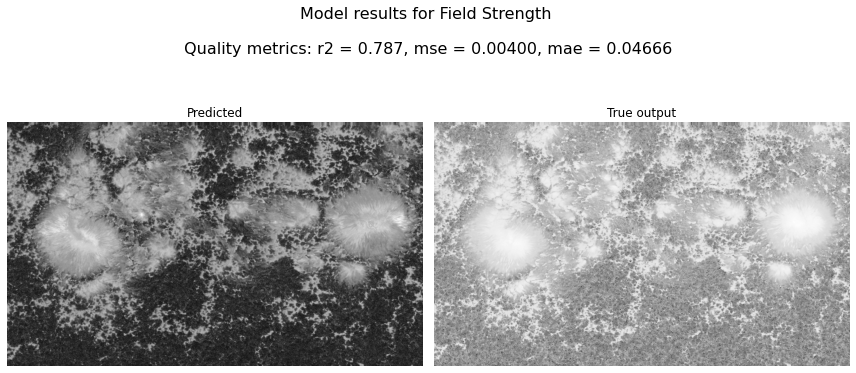

In [35]:
plot_pred_vs_refer(predicted_real, refer, output_index=0)

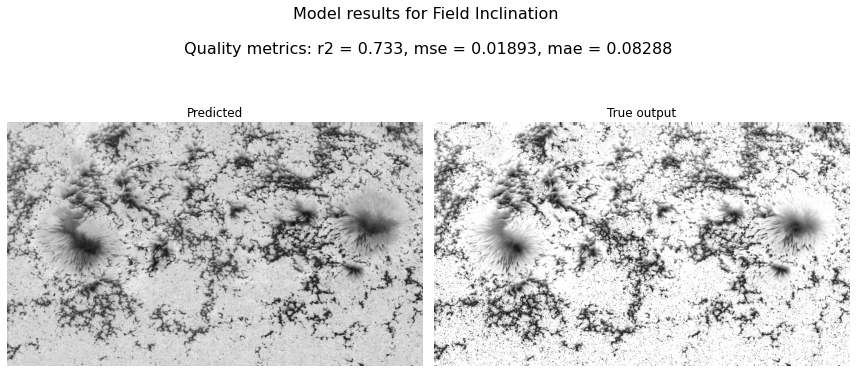

In [36]:
plot_pred_vs_refer(predicted_real, refer, output_index=1)

In [37]:
compute_metrics(refer, predicted_real)

,r2,mse,mae
Field Strength,0.787,0.004,0.047
Field Inclination,0.733,0.019,0.083
Field Azimuth,0.564,0.045,0.156
Doppler Width,0.169,0.038,0.157
Damping,0.300,0.039,0.156
Line Strength,0.160,0.088,0.256
S_0,0.081,0.094,0.289
S_1,0.000,0.083,0.253
Doppler Shift,0.036,0.004,0.050
Filling Factor,0.439,0.043,0.163
